# Introduction
* This program that classifies legal issues into a binary value for each National Subject Matter Index (NSMI). (https://nsmi.lsntap.org/browse-v2) \\
"Category" means 20 indexes. \\
"Class" means sub categories under the category.

### Data
* The data contains 2777 labeled articles. Each article has a binary value(0 or 1) that indicates if this article is related to a specific legal class. We ignore unlabeled entries when constructing a model.

### Implementation
* The program converts an article into tf-idf and applies multinomial Naive-Bayes model provided by scikit-learn. 

* After preprocessing data, we predict the model with 10-fold cross-validation.

### Output
* We calculate accuracy with bot categories(20) and classes(100+). \\

See overall result is at the bottom of this notebook.

# Data Preparation (DONE)

In [1]:
SOLVER = 'liblinear' 
PENALTY = "l1"


!pip3 install PrettyTable
!pip3 install pandas
!pip3 install sklearn
!pip3 install matplotlib
!pip3 install seaborn
!pip3 install tqdm
!pip3 install nltk
!python3 -m nltk.downloader stopwords punkt
!python3 -m pip install prettytable
from prettytable import PrettyTable
from collections import defaultdict

import collections
import os
import sys


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab as pl

import seaborn as sns; sns.set()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import log_loss, make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import brier_score_loss


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

from tqdm.notebook import tqdm

pd.options.display.max_rows = 100
pd.set_option('display.max_columns', None) 
print("DONE")

/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /Users/heeh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/heeh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


DONE


In [2]:
url = 'https://raw.githubusercontent.com/heeh/legal_issue_classification/master/2019-12-06_95p-confidence_binary.csv'
df = pd.read_csv(url)
df.info()
df.iloc[:,:4]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2777 entries, 0 to 2776
Columns: 109 entries, _id to WO-09-00-00-00
dtypes: float64(107), object(2)
memory usage: 2.3+ MB


,_id,full_text,BE-00-00-00-00,BE-01-00-00-00
0,5b60e59cda52255c20cff794,Will he serve time?. Long story short my broth...,0.0,0.0
1,5b60e59cda52255c20cff79a,Groundwater leaking out of street 24/7. Ground...,0.0,0.0
2,5b60e59cda52255c20cff7a0,How do I get my mom's license taken away. My m...,0.0,0.0
3,5b60e59cda52255c20cff7bf,My boss hasn't paid me. What do i do?. I work ...,NaN,NaN
4,5b60e59cda52255c20cff7b8,"[Texas] I signed a non-compete contract, but t...",0.0,0.0
...,...,...,...,...
2772,5b60e66dda52255c20df433f,Do you and your parents get deported because o...,0.0,0.0
2773,5b60e66dda52255c20df43ae,Wondering the legality of a minor (me) being a...,0.0,0.0
2774,5b60e66dda52255c20df4462,Can I sue a billion dollar company in small cl...,0.0,0.0
2775,5b60e66dda52255c20df4448,Sued by creditor and currently in settlement n...,0.0,0.0


## Null and Rowsum Check

In [3]:

#Null Check
#df.isnull().sum()

# Class Check - Remove every column that has zero sum. 
df = df.loc[:, df.sum(axis=0, skipna=True) != 0]
temp = df.sum(axis = 0, skipna = True)


#df.info()


# Remove columns that have <10 positive classes

In [4]:
oldCols = list(df.columns)
print(len(oldCols))

newCols = []
for i,x in temp[2:].items():
    if x >= 10:
        newCols.append(i)
        
print(len(newCols))

cols = oldCols[:2] + newCols

print(cols)
print(len(cols))

df = df[cols]

df.sum(axis=0, skipna=True)

88
36
['_id', 'full_text', 'BE-00-00-00-00', 'BU-00-00-00-00', 'CO-00-00-00-00', 'CR-00-00-00-00', 'CR-01-00-00-00', 'CR-04-00-00-00', 'CR-06-00-00-00', 'CR-10-00-00-00', 'ED-00-00-00-00', 'ES-00-00-00-00', 'ES-01-00-00-00', 'ES-03-00-00-00', 'FA-00-00-00-00', 'FA-05-00-00-00', 'FA-06-00-00-00', 'FA-07-00-00-00', 'GO-00-00-00-00', 'HE-00-00-00-00', 'HO-00-00-00-00', 'HO-06-00-00-00', 'HO-09-00-00-00', 'IM-00-00-00-00', 'MO-00-00-00-00', 'MO-02-00-00-00', 'MO-07-00-00-00', 'MO-10-00-00-00', 'RI-00-00-00-00', 'TO-00-00-00-00', 'TR-00-00-00-00', 'TR-01-00-00-00', 'TR-02-00-00-00', 'TR-03-00-00-00', 'TR-04-00-00-00', 'TR-05-00-00-00', 'WO-00-00-00-00', 'WO-03-00-00-00']
38


_id               5b60e59cda52255c20cff7945b60e59cda52255c20cff7...
full_text         Will he serve time?. Long story short my broth...
BE-00-00-00-00                                                   27
BU-00-00-00-00                                                   93
CO-00-00-00-00                                                  106
CR-00-00-00-00                                                  302
CR-01-00-00-00                                                   12
CR-04-00-00-00                                                   13
CR-06-00-00-00                                                   11
CR-10-00-00-00                                                   11
ED-00-00-00-00                                                   24
ES-00-00-00-00                                                   78
ES-01-00-00-00                                                   10
ES-03-00-00-00                                                   13
FA-00-00-00-00                                  

# Tiny Example: Crime and Prison(CR-00-00-00-00)


## Preprocessing (DONE)

In [5]:

verbose = True
def preprocessing(dfset: defaultdict, cls: str):
    dfset[cls] = df.loc[:, ['_id', 'full_text', cls]]
    labels = dfset[cls].iloc[:,2]
    if verbose:
        print("------------Before dropping nan----------------------------------------")
        print(dfset[cls].iloc[:,1:])
        print(labels.value_counts(dropna=False))
    
    dfset[cls] = dfset[cls].dropna()
    labels = dfset[cls].iloc[:,2]
    if verbose:
        print("\n------------After dropping nan---------------------------------------")
        print(dfset[cls].iloc[:,1:])
        print(labels.value_counts(dropna=False))



## Data Preparation

In [6]:

cls = 'CR-00-00-00-00'
dfset = defaultdict() 
preprocessing(dfset, cls)    

#    model[cls] = make_pipeline(TfidfVectorizer(), MultinomialNB())
tinydf = dfset[cls]
X = tinydf['full_text'].values
Y = tinydf[cls].values


------------Before dropping nan----------------------------------------
                                              full_text  CR-00-00-00-00
0     Will he serve time?. Long story short my broth...             1.0
1     Groundwater leaking out of street 24/7. Ground...             0.0
2     How do I get my mom's license taken away. My m...             NaN
3     My boss hasn't paid me. What do i do?. I work ...             0.0
4     [Texas] I signed a non-compete contract, but t...             0.0
...                                                 ...             ...
2772  Do you and your parents get deported because o...             1.0
2773  Wondering the legality of a minor (me) being a...             0.0
2774  Can I sue a billion dollar company in small cl...             0.0
2775  Sued by creditor and currently in settlement n...             0.0
2776  (CA) Sales job. Income based on performance. A...             0.0

[2777 rows x 2 columns]
0.0    1377
NaN    1098
1.0     302
Nam

In [7]:
class_list = df.columns[2:].tolist()

for cls in tqdm(class_list):
    preprocessing(dfset, cls)

------------Before dropping nan----------------------------------------
                                              full_text  BE-00-00-00-00
0     Will he serve time?. Long story short my broth...             0.0
1     Groundwater leaking out of street 24/7. Ground...             0.0
2     How do I get my mom's license taken away. My m...             0.0
3     My boss hasn't paid me. What do i do?. I work ...             NaN
4     [Texas] I signed a non-compete contract, but t...             0.0
...                                                 ...             ...
2772  Do you and your parents get deported because o...             0.0
2773  Wondering the legality of a minor (me) being a...             0.0
2774  Can I sue a billion dollar company in small cl...             0.0
2775  Sued by creditor and currently in settlement n...             0.0
2776  (CA) Sales job. Income based on performance. A...             0.0

[2777 rows x 2 columns]
0.0    1821
NaN     929
1.0      27
Nam

------------After dropping nan---------------------------------------
                                              full_text  ED-00-00-00-00
0     Will he serve time?. Long story short my broth...             0.0
1     Groundwater leaking out of street 24/7. Ground...             0.0
3     My boss hasn't paid me. What do i do?. I work ...             0.0
4     [Texas] I signed a non-compete contract, but t...             0.0
5     TX - TSA and Police accidental law broken. Oka...             0.0
...                                                 ...             ...
2765  Massachusetts firearms license and arrest reco...             0.0
2767  QC, Canada. How many seconds of a clip can I u...             0.0
2771  [GA] At what point does poor quality of care b...             0.0
2774  Can I sue a billion dollar company in small cl...             0.0
2776  (CA) Sales job. Income based on performance. A...             0.0

[1813 rows x 2 columns]
0.0    1789
1.0      24
Name: ED-00-00-00

Name: FA-07-00-00-00, dtype: int64

------------After dropping nan---------------------------------------
                                              full_text  FA-07-00-00-00
0     Will he serve time?. Long story short my broth...             0.0
1     Groundwater leaking out of street 24/7. Ground...             0.0
2     How do I get my mom's license taken away. My m...             0.0
3     My boss hasn't paid me. What do i do?. I work ...             0.0
4     [Texas] I signed a non-compete contract, but t...             0.0
...                                                 ...             ...
2771  [GA] At what point does poor quality of care b...             0.0
2773  Wondering the legality of a minor (me) being a...             0.0
2774  Can I sue a billion dollar company in small cl...             0.0
2775  Sued by creditor and currently in settlement n...             0.0
2776  (CA) Sales job. Income based on performance. A...             0.0

[1968 rows x 2 columns]
0.0  

[1662 rows x 2 columns]
0.0    1628
1.0      34
Name: HO-06-00-00-00, dtype: int64
------------Before dropping nan----------------------------------------
                                              full_text  HO-09-00-00-00
0     Will he serve time?. Long story short my broth...             0.0
1     Groundwater leaking out of street 24/7. Ground...             NaN
2     How do I get my mom's license taken away. My m...             0.0
3     My boss hasn't paid me. What do i do?. I work ...             0.0
4     [Texas] I signed a non-compete contract, but t...             0.0
...                                                 ...             ...
2772  Do you and your parents get deported because o...             0.0
2773  Wondering the legality of a minor (me) being a...             0.0
2774  Can I sue a billion dollar company in small cl...             0.0
2775  Sued by creditor and currently in settlement n...             0.0
2776  (CA) Sales job. Income based on performance. A.


------------After dropping nan---------------------------------------
                                              full_text  RI-00-00-00-00
0     Will he serve time?. Long story short my broth...             0.0
1     Groundwater leaking out of street 24/7. Ground...             0.0
3     My boss hasn't paid me. What do i do?. I work ...             0.0
5     TX - TSA and Police accidental law broken. Oka...             0.0
6     Eviction. I got an eviction notice from my lan...             0.0
...                                                 ...             ...
2754  Cigna denied my FMLA paperwork because of a sm...             0.0
2759  How much of a music clip can I use in a short ...             0.0
2767  QC, Canada. How many seconds of a clip can I u...             0.0
2771  [GA] At what point does poor quality of care b...             0.0
2774  Can I sue a billion dollar company in small cl...             0.0

[1396 rows x 2 columns]
0.0    1374
1.0      22
Name: RI-00-00-0


------------After dropping nan---------------------------------------
                                              full_text  TR-04-00-00-00
0     Will he serve time?. Long story short my broth...             0.0
1     Groundwater leaking out of street 24/7. Ground...             0.0
3     My boss hasn't paid me. What do i do?. I work ...             0.0
4     [Texas] I signed a non-compete contract, but t...             0.0
5     TX - TSA and Police accidental law broken. Oka...             0.0
...                                                 ...             ...
2772  Do you and your parents get deported because o...             0.0
2773  Wondering the legality of a minor (me) being a...             0.0
2774  Can I sue a billion dollar company in small cl...             0.0
2775  Sued by creditor and currently in settlement n...             0.0
2776  (CA) Sales job. Income based on performance. A...             0.0

[1815 rows x 2 columns]
0.0    1795
1.0      20
Name: TR-04-00-0

# TF-IDF

## TF-IDF using stopwords, ngram, and C value

In [8]:

p = len(X) // 10 * 9
#tfidf_vect = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_df=300 )
tfidf_vect = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_df=0.3)
#tfidf_vect.fit(X[0:p])
tfidf_vect.fit(X)
X_train_tfidf_vect = tfidf_vect.transform(X[0:p])
X_test_tfidf_vect = tfidf_vect.transform(X[p:])

model = LogisticRegression(penalty=PENALTY, solver=SOLVER, class_weight='balanced')
model.fit(X_train_tfidf_vect, Y[0:p])
preds = model.predict(X_test_tfidf_vect)
precision, recall, fscore, support = score(Y[p:], preds, average='binary')
print('accuracy : {0:.4f}'.format(accuracy_score(Y[p:], preds)))
print('precision: {0:.4f}'.format(precision))
print('recall   : {0:.4f}'.format(recall))
print('fscore   : {0:.4f}'.format(fscore))

print("TF-IDF Dimension: ", len(tfidf_vect.vocabulary_))


accuracy : 0.9375
precision: 0.7500
recall   : 0.7826
fscore   : 0.7660
TF-IDF Dimension:  139065


## TF-IDF + Logistic Regression on CR-00-00-00-00

In [9]:

def predict_by_class_tfidf(dfset: defaultdict,cls: str, model) -> float:
    global tfidf_vect
    preprocessing(dfset, cls)
    tinydf = dfset[cls]
    X = tinydf['full_text'].values
    Y = tinydf[cls].values
    print('------------------------------------\n')
    labels = dfset[cls].iloc[:,2]
    print(labels.value_counts(dropna=False))

    kfold = KFold(n_splits=10)
    print('data set size', len(X))
    numdoc[cls] = len(X)
    n_iter = 0
    acc_list = []
    pre_list = []
    rec_list = []
    fsc_list = []
    sup_list = []
    preds = [0] * len(Y)

    for train_index, test_index in kfold.split(X, Y):
        X_train, X_test = X[train_index], X[test_index] 
        Y_train, Y_test = Y[train_index], Y[test_index] 
        
#        tfidf_vect = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_df=0.3)
#        tfidf_vect.fit(X_train)
        X_train_tfidf = tfidf_vect.transform(X_train)
        X_test_tfidf = tfidf_vect.transform(X_test)
        
        model.fit(X_train_tfidf, Y_train)
        out = model.predict(X_test_tfidf)
        i = 0
        for x in test_index:
            preds[x] = out[i]
            i += 1
        n_iter += 1
        
    accuracy = accuracy_score(Y, preds)
    precision, recall, fscore, support = score(Y, preds)
    # accuracy: (tp + tn) / (p + n)
    # precision tp / (tp + fp)
    # recall: tp / (tp + fn)
    # f1: 2 tp / (2 tp + fp + fn)
    accuracy = np.round(accuracy, 4)
    precision[1] = np.round(precision[1], 4)
    recall[1] = np.round(recall[1], 4)
    fscore[1] = np.round(fscore[1], 4)
    support[1] = np.round(support[1], 4)    
    return (accuracy, precision[1], recall[1], fscore[1], support[1])

verbose = False 
numdoc = defaultdict()
model = LogisticRegression(penalty=PENALTY, solver=SOLVER, class_weight='balanced', max_iter=2000)

cls = 'CR-00-00-00-00'
predict_by_class_tfidf(dfset, cls, model)

------------------------------------

0.0    1377
1.0     302
Name: CR-00-00-00-00, dtype: int64
data set size 1679


(0.8952, 0.7188, 0.6854, 0.7017, 302)

## Optimize model using gridsearch, cross validation, and log_loss

In [10]:
def predict_tfidf_grid_sklearn(dfset: defaultdict,cls: str):
    global PENALTY, SOLVER
    parameters = {'C': [1.0/2.0**reg for reg in np.arange(-12, 12)]}
    lr = LogisticRegression(penalty=PENALTY, solver=SOLVER, class_weight='balanced', max_iter=2000)
    grid_search = GridSearchCV(lr, parameters, cv=10, refit=True, 
                               scoring=make_scorer(log_loss, greater_is_better=False))
    grid_search.fit(X_train_tfidf_vect, Y[:p])

    best_model = grid_search.best_estimator_
    print(best_model)

    preds = best_model.predict(X_test_tfidf_vect)
    precision, recall, fscore, support = score(Y[p:], preds, average='binary')
    print('accuracy : {0:.4f}'.format(accuracy_score(Y[p:], preds)))
    print('precision: {0:.4f}'.format(precision))
    print('recall   : {0:.4f}'.format(recall))
    print('fscore   : {0:.4f}'.format(fscore))

    
    return (accuracy_score(Y[p:], preds), precision, recall, fscore)
cls = 'CR-00-00-00-00'
print(predict_tfidf_grid_sklearn(dfset, cls))




LogisticRegression(C=32.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=2000, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
accuracy : 0.9375
precision: 0.8333
recall   : 0.6522
fscore   : 0.7317
(0.9375, 0.8333333333333334, 0.6521739130434783, 0.7317073170731708)


## TFIDF Hyperparameter Selection 

------------------------------------

Class:  CR-00-00-00-00
0.0    1377
1.0     302
Name: CR-00-00-00-00, dtype: int64
data set size 1679
C: 32.0 Loss:  0.2324
C: 16.0 Loss:  0.2196
C: 8.0 Loss:  0.2216
C: 4.0 Loss:  0.2527
C: 2.0 Loss:  0.3147
C: 1.0 Loss:  0.4116
(0.9196, 0.8224, 0.7053, 0.7594, 302, 0.2196, 0.0623, 16.0, 1679)
LogisticRegression(C=16.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=2000, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
6


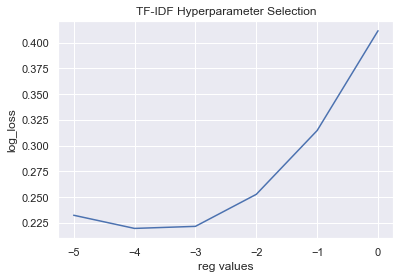

16.0


In [11]:
def predict_by_class_gridcv(dfset: defaultdict,cls: str):
    global PENALTY, SOLVER
    global tfidf_vect
    print('------------------------------------\n')
    print('Class: ', cls)
    #preprocessing(dfset, cls)
    tinydf = dfset[cls]
    X = tinydf['full_text'].values
    Y = tinydf[cls].values

    labels = dfset[cls].iloc[:,2]
    print(labels.value_counts(dropna=False))

    kfold = KFold(n_splits=10)
    print('data set size', len(X))
    numdoc[cls] = len(X)
    n_iter = 0
    acc_list = []
    pre_list = []
    rec_list = []
    fsc_list = []
    sup_list = []
    preds = [0] * len(Y)
    probs = [0] * len(Y)
    
    best_recall = 0
    best_accuracy = 0
    best_precision = 0
    best_fscore = 0
    best_support = 0
    best_model = 0
    
    best_c = 0
    
    best_logloss = 1
    best_brierloss = 1
    
    for c in [1.0/2.0**reg for reg in np.arange(-5, 1)]:

        model = LogisticRegression(penalty=PENALTY, solver=SOLVER, class_weight='balanced', C = c, max_iter=2000)
    
        for train_index, test_index in kfold.split(X, Y):
            X_train, X_test = X[train_index], X[test_index] 
            Y_train, Y_test = Y[train_index], Y[test_index] 

            #tfidf_vect = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_df=0.3)
            #tfidf_vect.fit(X_train)
            X_train_tfidf = tfidf_vect.transform(X_train)
            X_test_tfidf = tfidf_vect.transform(X_test)

            model.fit(X_train_tfidf, Y_train)
            out = model.predict(X_test_tfidf)
            prob = model.predict_proba(X_test_tfidf)[:,1]
            i = 0
            for x in test_index:
                preds[x] = out[i]
                probs[x] = prob[i]
                i += 1
            n_iter += 1

        custom_logloss = np.round(log_loss(Y, probs), 4)
        custom_brierloss = np.round(brier_score_loss(Y, probs), 4)  

        c_list.append(c)
        loss_list.append(custom_logloss)
        
        print('C:', c, end=' ')
        print('Loss: ', np.round(custom_logloss, 4))
        
        
        
        
        accuracy = accuracy_score(Y, preds)
        precision, recall, fscore, support = score(Y, preds)
        # accuracy: (tp + tn) / (p + n)
        # precision tp / (tp + fp)
        # recall: tp / (tp + fn)
        # f1: 2 tp / (2 tp + fp + fn)
        accuracy = np.round(accuracy, 4)
        precision[1] = np.round(precision[1], 4)
        recall[1] = np.round(recall[1], 4)
        fscore[1] = np.round(fscore[1], 4)
        support[1] = np.round(support[1], 4)    
#        print(accuracy, precision[1], recall[1], fscore[1], support[1])
        
        #if best_recall < recall[1]: #For best recall score
        if best_logloss > custom_logloss: 
            best_logloss = custom_logloss
            best_accuracy = accuracy
            best_recall = recall[1]
            best_precision = precision[1]
            best_fscore = fscore[1]
            best_support = support[1]
            best_model = model
            best_c = c
        if best_brierloss > custom_brierloss:
            best_brierloss = custom_brierloss
            
    classifier[cls] = best_model
    return (best_accuracy, best_precision, best_recall, best_fscore, best_support, best_logloss, best_brierloss, best_c, numdoc[cls])


c_list = []
loss_list = []

classifier = defaultdict()
numdoc = defaultdict()
cls = 'CR-00-00-00-00'
print(predict_by_class_gridcv(dfset, cls))
print(classifier[cls])

print(len(loss_list))

# plotting the points  
plt.plot(range(-5,1), loss_list)  
plt.xlabel('reg values') 
plt.ylabel('log_loss') 
plt.title('TF-IDF Hyperparameter Selection') 
plt.show() 
print(classifier[cls].C)


# Entire Data 

## Build Models and Calculating Accuracies

In [12]:
class_list = df.columns[2:].tolist()
print(class_list)
verbose = False
stat_dict = defaultdict() 
for cls in tqdm(class_list):
    ret = predict_by_class_gridcv(dfset, cls)
    stat_dict[cls] = ret 
    print('statistics' , ret)

['BE-00-00-00-00', 'BU-00-00-00-00', 'CO-00-00-00-00', 'CR-00-00-00-00', 'CR-01-00-00-00', 'CR-04-00-00-00', 'CR-06-00-00-00', 'CR-10-00-00-00', 'ED-00-00-00-00', 'ES-00-00-00-00', 'ES-01-00-00-00', 'ES-03-00-00-00', 'FA-00-00-00-00', 'FA-05-00-00-00', 'FA-06-00-00-00', 'FA-07-00-00-00', 'GO-00-00-00-00', 'HE-00-00-00-00', 'HO-00-00-00-00', 'HO-06-00-00-00', 'HO-09-00-00-00', 'IM-00-00-00-00', 'MO-00-00-00-00', 'MO-02-00-00-00', 'MO-07-00-00-00', 'MO-10-00-00-00', 'RI-00-00-00-00', 'TO-00-00-00-00', 'TR-00-00-00-00', 'TR-01-00-00-00', 'TR-02-00-00-00', 'TR-03-00-00-00', 'TR-04-00-00-00', 'TR-05-00-00-00', 'WO-00-00-00-00', 'WO-03-00-00-00']


------------------------------------

Class:  BE-00-00-00-00
0.0    1821
1.0      27
Name: BE-00-00-00-00, dtype: int64
data set size 1848


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 32.0 Loss:  0.0609


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 16.0 Loss:  0.0559


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 8.0 Loss:  0.0563


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 4.0 Loss:  0.0635
C: 2.0 Loss:  0.0831
C: 1.0 Loss:  0.1259
statistics (0.9865, 0.55, 0.4074, 0.4681, 27, 0.0559, 0.0115, 16.0, 1848)
------------------------------------

Class:  BU-00-00-00-00
0.0    1497
1.0      93
Name: BU-00-00-00-00, dtype: int64
data set size 1590


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 32.0 Loss:  0.1359
C: 16.0 Loss:  0.1258


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 8.0 Loss:  0.1235
C: 4.0 Loss:  0.1338
C: 2.0 Loss:  0.1727
C: 1.0 Loss:  0.2512
statistics (0.9597, 0.7042, 0.5376, 0.6098, 93, 0.1235, 0.0318, 8.0, 1590)
------------------------------------

Class:  CO-00-00-00-00
0.0    1058
1.0     106
Name: CO-00-00-00-00, dtype: int64
data set size 1164


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 32.0 Loss:  0.1906


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 16.0 Loss:  0.1739
C: 8.0 Loss:  0.1712
C: 4.0 Loss:  0.1904
C: 2.0 Loss:  0.2421
C: 1.0 Loss:  0.3287
statistics (0.9407, 0.6762, 0.6698, 0.673, 106, 0.1712, 0.0461, 8.0, 1164)
------------------------------------

Class:  CR-00-00-00-00
0.0    1377
1.0     302
Name: CR-00-00-00-00, dtype: int64
data set size 1679
C: 32.0 Loss:  0.2324


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 16.0 Loss:  0.2196
C: 8.0 Loss:  0.2216
C: 4.0 Loss:  0.2527
C: 2.0 Loss:  0.3147
C: 1.0 Loss:  0.4116
statistics (0.9196, 0.8224, 0.7053, 0.7594, 302, 0.2196, 0.0623, 16.0, 1679)
------------------------------------

Class:  CR-01-00-00-00
0.0    1381
1.0      12
Name: CR-01-00-00-00, dtype: int64
data set size 1393


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_b

C: 32.0 Loss:  0.0533


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 16.0 Loss:  0.0506


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 8.0 Loss:  0.0501


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 4.0 Loss:  0.0528
C: 2.0 Loss:  0.0631


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 1.0 Loss:  0.0917
statistics (0.9871, 0.125, 0.0833, 0.1, 12, 0.0501, 0.0092, 8.0, 1393)
------------------------------------

Class:  CR-04-00-00-00
0.0    1389
1.0      13
Name: CR-04-00-00-00, dtype: int64
data set size 1402


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_b

C: 32.0 Loss:  0.06


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 16.0 Loss:  0.0554


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 8.0 Loss:  0.0543


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 4.0 Loss:  0.0585
C: 2.0 Loss:  0.0734


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 1.0 Loss:  0.1101
statistics (0.9886, 0.2, 0.0769, 0.1111, 13, 0.0543, 0.0104, 8.0, 1402)
------------------------------------

Class:  CR-06-00-00-00
0.0    1393
1.0      11
Name: CR-06-00-00-00, dtype: int64
data set size 1404


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_b

C: 32.0 Loss:  0.052


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 16.0 Loss:  0.0485


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 8.0 Loss:  0.0468


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 4.0 Loss:  0.0493


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 2.0 Loss:  0.0595
C: 1.0 Loss:  0.0859
statistics (0.9915, 0.0, 0.0, 0.0, 11, 0.0468, 0.0081, 8.0, 1404)
------------------------------------

Class:  CR-10-00-00-00
0.0    1958
1.0      11
Name: CR-10-00-00-00, dtype: int64
data set size 1969


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_b

C: 32.0 Loss:  0.0471


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_b

C: 16.0 Loss:  0.0439


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 8.0 Loss:  0.0428


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 4.0 Loss:  0.0452


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 2.0 Loss:  0.0551


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 1.0 Loss:  0.0776
statistics (0.9924, 0.0, 0.0, 0.0, 11, 0.0428, 0.0069, 8.0, 1969)
------------------------------------

Class:  ED-00-00-00-00
0.0    1789
1.0      24
Name: ED-00-00-00-00, dtype: int64
data set size 1813


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 32.0 Loss:  0.0397


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 16.0 Loss:  0.038
C: 8.0 Loss:  0.0381
C: 4.0 Loss:  0.0434
C: 2.0 Loss:  0.058


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 1.0 Loss:  0.0932
statistics (0.989, 0.625, 0.4167, 0.5, 24, 0.038, 0.0089, 16.0, 1813)
------------------------------------

Class:  ES-00-00-00-00
0.0    1866
1.0      78
Name: ES-00-00-00-00, dtype: int64
data set size 1944


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 32.0 Loss:  0.0928


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 16.0 Loss:  0.0887
C: 8.0 Loss:  0.0885


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 4.0 Loss:  0.0997


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 2.0 Loss:  0.1254
C: 1.0 Loss:  0.1735
statistics (0.9753, 0.6974, 0.6795, 0.6883, 78, 0.0885, 0.019, 8.0, 1944)
------------------------------------

Class:  ES-01-00-00-00
0.0    1866
1.0      10
Name: ES-01-00-00-00, dtype: int64
data set size 1876


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 32.0 Loss:  0.0435


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 16.0 Loss:  0.0411


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 8.0 Loss:  0.0399


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 4.0 Loss:  0.0418


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 2.0 Loss:  0.0498


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 1.0 Loss:  0.0695
statistics (0.9925, 0.0, 0.0, 0.0, 10, 0.0399, 0.0068, 8.0, 1876)
------------------------------------

Class:  ES-03-00-00-00
0.0    1979
1.0      13
Name: ES-03-00-00-00, dtype: int64
data set size 1992


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 32.0 Loss:  0.0485


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 16.0 Loss:  0.0446


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 8.0 Loss:  0.0427


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 4.0 Loss:  0.0439


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 2.0 Loss:  0.0507


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 1.0 Loss:  0.07
statistics (0.993, 0.4, 0.1538, 0.2222, 13, 0.0427, 0.0069, 8.0, 1992)
------------------------------------

Class:  FA-00-00-00-00
0.0    1685
1.0     357
Name: FA-00-00-00-00, dtype: int64
data set size 2042
C: 32.0 Loss:  0.1804


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 16.0 Loss:  0.1647
C: 8.0 Loss:  0.1587


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 4.0 Loss:  0.1705
C: 2.0 Loss:  0.2033
C: 1.0 Loss:  0.2512
statistics (0.9427, 0.8468, 0.8207, 0.8336, 357, 0.1587, 0.0428, 8.0, 2042)
------------------------------------

Class:  FA-05-00-00-00
0.0    2001
1.0      10
Name: FA-05-00-00-00, dtype: int64
data set size 2011


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 32.0 Loss:  0.0303


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 16.0 Loss:  0.0273
C: 8.0 Loss:  0.0255
C: 4.0 Loss:  0.0313


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 2.0 Loss:  0.0434
C: 1.0 Loss:  0.0527
statistics (0.991, 0.1667, 0.2, 0.1818, 10, 0.0255, 0.0061, 8.0, 2011)
------------------------------------

Class:  FA-06-00-00-00
0.0    1781
1.0      10
Name: FA-06-00-00-00, dtype: int64
data set size 1791


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 32.0 Loss:  0.0158


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 16.0 Loss:  0.0163
C: 8.0 Loss:  0.0181


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 4.0 Loss:  0.0221
C: 2.0 Loss:  0.0313
C: 1.0 Loss:  0.0475
statistics (0.9966, 1.0, 0.4, 0.5714, 10, 0.0158, 0.0028, 32.0, 1791)
------------------------------------

Class:  FA-07-00-00-00
0.0    1927
1.0      41
Name: FA-07-00-00-00, dtype: int64
data set size 1968


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_b

C: 32.0 Loss:  0.1124


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 16.0 Loss:  0.105


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 8.0 Loss:  0.1043


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 4.0 Loss:  0.1132


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 2.0 Loss:  0.1388
C: 1.0 Loss:  0.1919
statistics (0.9715, 0.2727, 0.2195, 0.2432, 41, 0.1043, 0.0218, 8.0, 1968)
------------------------------------

Class:  GO-00-00-00-00
0.0    1504
1.0      13
Name: GO-00-00-00-00, dtype: int64
data set size 1517


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_b

C: 32.0 Loss:  0.0727


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 16.0 Loss:  0.0692


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 8.0 Loss:  0.0676


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 4.0 Loss:  0.0704


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 2.0 Loss:  0.0819


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 1.0 Loss:  0.113
statistics (0.9848, 0.0, 0.0, 0.0, 13, 0.0676, 0.0121, 8.0, 1517)
------------------------------------

Class:  HE-00-00-00-00
0.0    1778
1.0     122
Name: HE-00-00-00-00, dtype: int64
data set size 1900


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 32.0 Loss:  0.1069
C: 16.0 Loss:  0.0996


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 8.0 Loss:  0.0986
C: 4.0 Loss:  0.1099
C: 2.0 Loss:  0.143
C: 1.0 Loss:  0.213
statistics (0.97, 0.7876, 0.7295, 0.7574, 122, 0.0986, 0.0246, 8.0, 1900)
------------------------------------

Class:  HO-00-00-00-00
0.0    1582
1.0     550
Name: HO-00-00-00-00, dtype: int64
data set size 2132
C: 32.0 Loss:  0.121
C: 16.0 Loss:  0.1148
C: 8.0 Loss:  0.1148
C: 4.0 Loss:  0.123
C: 2.0 Loss:  0.147
C: 1.0 Loss:  0.1859
statistics (0.9629, 0.9469, 0.9073, 0.9266, 550, 0.1148, 0.0288, 16.0, 2132)
------------------------------------

Class:  HO-06-00-00-00
0.0    1628
1.0      34
Name: HO-06-00-00-00, dtype: int64
data set size 1662


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 32.0 Loss:  0.0642
C: 16.0 Loss:  0.0603
C: 8.0 Loss:  0.0594
C: 4.0 Loss:  0.0622


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 2.0 Loss:  0.078
C: 1.0 Loss:  0.1137
statistics (0.9868, 0.75, 0.5294, 0.6207, 34, 0.0594, 0.0116, 8.0, 1662)
------------------------------------

Class:  HO-09-00-00-00
0.0    1626
1.0      27
Name: HO-09-00-00-00, dtype: int64
data set size 1653


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 32.0 Loss:  0.0509
C: 16.0 Loss:  0.0491
C: 8.0 Loss:  0.0481
C: 4.0 Loss:  0.052
C: 2.0 Loss:  0.0647
C: 1.0 Loss:  0.0939
statistics (0.9867, 0.6471, 0.4074, 0.5, 27, 0.0481, 0.0111, 8.0, 1653)
------------------------------------

Class:  IM-00-00-00-00
0.0    1928
1.0      36
Name: IM-00-00-00-00, dtype: int64
data set size 1964


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 32.0 Loss:  0.0472


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 16.0 Loss:  0.0448


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 8.0 Loss:  0.0452


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 4.0 Loss:  0.0506
C: 2.0 Loss:  0.0667
C: 1.0 Loss:  0.0965
statistics (0.9878, 0.7143, 0.5556, 0.625, 36, 0.0448, 0.0103, 16.0, 1964)
------------------------------------

Class:  MO-00-00-00-00
0.0    1063
1.0     366
Name: MO-00-00-00-00, dtype: int64
data set size 1429
C: 32.0 Loss:  0.3258
C: 16.0 Loss:  0.2984
C: 8.0 Loss:  0.2867
C: 4.0 Loss:  0.3016
C: 2.0 Loss:  0.3508
C: 1.0 Loss:  0.4337
statistics (0.8943, 0.8267, 0.7432, 0.7827, 366, 0.2867, 0.0821, 8.0, 1429)
------------------------------------

Class:  MO-02-00-00-00
0.0    1937
1.0      12
Name: MO-02-00-00-00, dtype: int64
data set size 1949


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 32.0 Loss:  0.0605


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_b

C: 16.0 Loss:  0.0566


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_b

C: 8.0 Loss:  0.0549


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 4.0 Loss:  0.0586


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_b

C: 2.0 Loss:  0.0667
C: 1.0 Loss:  0.091
statistics (0.9903, 0.0, 0.0, 0.0, 12, 0.0549, 0.0095, 8.0, 1949)
------------------------------------

Class:  MO-07-00-00-00
0.0    1116
1.0      13
Name: MO-07-00-00-00, dtype: int64
data set size 1129


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 32.0 Loss:  0.0369


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 16.0 Loss:  0.0341


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 8.0 Loss:  0.0323
C: 4.0 Loss:  0.0375
C: 2.0 Loss:  0.0479
C: 1.0 Loss:  0.0613
statistics (0.9903, 0.5556, 0.7692, 0.6452, 13, 0.0323, 0.0078, 8.0, 1129)
------------------------------------

Class:  MO-10-00-00-00
0.0    1095
1.0      11
Name: MO-10-00-00-00, dtype: int64
data set size 1106


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 32.0 Loss:  0.0596


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 16.0 Loss:  0.0553
C: 8.0 Loss:  0.0526
C: 4.0 Loss:  0.0546


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 2.0 Loss:  0.0662
C: 1.0 Loss:  0.0927
statistics (0.9873, 0.2857, 0.1818, 0.2222, 11, 0.0526, 0.0091, 8.0, 1106)
------------------------------------

Class:  RI-00-00-00-00
0.0    1374
1.0      22
Name: RI-00-00-00-00, dtype: int64
data set size 1396


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 32.0 Loss:  0.105


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 16.0 Loss:  0.0979


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 8.0 Loss:  0.0967


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 4.0 Loss:  0.1041
C: 2.0 Loss:  0.1264
C: 1.0 Loss:  0.1847
statistics (0.9792, 0.0, 0.0, 0.0, 22, 0.0967, 0.0178, 8.0, 1396)
------------------------------------

Class:  TO-00-00-00-00
0.0    1027
1.0     230
Name: TO-00-00-00-00, dtype: int64
data set size 1257
C: 32.0 Loss:  0.3052
C: 16.0 Loss:  0.2823
C: 8.0 Loss:  0.2799
C: 4.0 Loss:  0.3058
C: 2.0 Loss:  0.3815
C: 1.0 Loss:  0.5026
statistics (0.8807, 0.7062, 0.5957, 0.6462, 230, 0.2799, 0.0814, 8.0, 1257)
------------------------------------

Class:  TR-00-00-00-00
0.0    1746
1.0     260
Name: TR-00-00-00-00, dtype: int64
data set size 2006
C: 32.0 Loss:  0.1061


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 16.0 Loss:  0.0991
C: 8.0 Loss:  0.0992
C: 4.0 Loss:  0.1141
C: 2.0 Loss:  0.1447
C: 1.0 Loss:  0.1907
statistics (0.9656, 0.8775, 0.8538, 0.8655, 260, 0.0991, 0.0247, 16.0, 2006)
------------------------------------

Class:  TR-01-00-00-00
0.0    1805
1.0      22
Name: TR-01-00-00-00, dtype: int64
data set size 1827


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 32.0 Loss:  0.0714
C: 16.0 Loss:  0.0651


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 8.0 Loss:  0.0585
C: 4.0 Loss:  0.0602
C: 2.0 Loss:  0.0729
C: 1.0 Loss:  0.0955
statistics (0.9863, 0.4118, 0.3182, 0.359, 22, 0.0585, 0.011, 8.0, 1827)
------------------------------------

Class:  TR-02-00-00-00
0.0    1790
1.0      29
Name: TR-02-00-00-00, dtype: int64
data set size 1819


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 32.0 Loss:  0.0682


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 16.0 Loss:  0.0642
C: 8.0 Loss:  0.0633
C: 4.0 Loss:  0.0664
C: 2.0 Loss:  0.0796
C: 1.0 Loss:  0.1083
statistics (0.9841, 0.5, 0.3793, 0.4314, 29, 0.0633, 0.0138, 8.0, 1819)
------------------------------------

Class:  TR-03-00-00-00
0.0    1804
1.0      17
Name: TR-03-00-00-00, dtype: int64
data set size 1821


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 32.0 Loss:  0.0518


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 16.0 Loss:  0.0485
C: 8.0 Loss:  0.0462
C: 4.0 Loss:  0.0474
C: 2.0 Loss:  0.0562
C: 1.0 Loss:  0.0781
statistics (0.9885, 0.3, 0.1765, 0.2222, 17, 0.0462, 0.0094, 8.0, 1821)
------------------------------------

Class:  TR-04-00-00-00
0.0    1795
1.0      20
Name: TR-04-00-00-00, dtype: int64
data set size 1815


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 32.0 Loss:  0.0531


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 16.0 Loss:  0.0496


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 8.0 Loss:  0.0479
C: 4.0 Loss:  0.051


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 2.0 Loss:  0.0621
C: 1.0 Loss:  0.0876
statistics (0.989, 0.5, 0.4, 0.4444, 20, 0.0479, 0.0096, 8.0, 1815)
------------------------------------

Class:  TR-05-00-00-00
0.0    1785
1.0      31
Name: TR-05-00-00-00, dtype: int64
data set size 1816


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 32.0 Loss:  0.017


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 16.0 Loss:  0.0176
C: 8.0 Loss:  0.0201
C: 4.0 Loss:  0.0265
C: 2.0 Loss:  0.0375
C: 1.0 Loss:  0.0566
statistics (0.9967, 0.931, 0.871, 0.9, 31, 0.017, 0.0033, 32.0, 1816)
------------------------------------

Class:  WO-00-00-00-00
0.0    1604
1.0     387
Name: WO-00-00-00-00, dtype: int64
data set size 1991


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 32.0 Loss:  0.1552
C: 16.0 Loss:  0.146
C: 8.0 Loss:  0.1472
C: 4.0 Loss:  0.1634
C: 2.0 Loss:  0.2043
C: 1.0 Loss:  0.2646
statistics (0.9513, 0.9119, 0.8295, 0.8687, 387, 0.146, 0.0378, 16.0, 1991)
------------------------------------

Class:  WO-03-00-00-00
0.0    1607
1.0      10
Name: WO-03-00-00-00, dtype: int64
data set size 1617


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 32.0 Loss:  0.0397


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 16.0 Loss:  0.0403
C: 8.0 Loss:  0.0417
C: 4.0 Loss:  0.0465


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 2.0 Loss:  0.0588
C: 1.0 Loss:  0.0774
statistics (0.9932, 0.4286, 0.3, 0.3529, 10, 0.0397, 0.0066, 32.0, 1617)



In [13]:
import pickle
with open("models_tfidf_l1.pckl", "wb") as f:
    for val in classifier.items():
         pickle.dump(val, f)
            
with open("stats_tfidf_l1.pckl", "wb") as f:
    for val in stat_dict.items():
         pickle.dump(val, f)

## Distribution

In [21]:

t = PrettyTable(["class", "accuracy", "precision", "recall", "F1", "support", "log_loss", "brier_loss", "C", "|documents|"])
#t.align["class"] = "r"
t.align["accuracy"] = "r"
t.align["precision"] = "r"
t.align["recall"] = "r"
t.align["F1 score"] = "r"
t.align["support"] = "r"
t.align["log_loss"] = "r"
t.align["brier_loss"] = "r"
t.align["C"] = "r"

for k,v in stat_dict.items():
    t.add_row([k, v[0], v[1], v[2], v[3], v[4], v[5], v[6], v[7], numdoc[k]])
    
print(t)

+----------------+----------+-----------+--------+--------+---------+----------+------------+------+-------------+
|     class      | accuracy | precision | recall |   F1   | support | log_loss | brier_loss |    C | |documents| |
+----------------+----------+-----------+--------+--------+---------+----------+------------+------+-------------+
| BE-00-00-00-00 |   0.9865 |      0.55 | 0.4074 | 0.4681 |      27 |   0.0559 |     0.0115 | 16.0 |     1848    |
| BU-00-00-00-00 |   0.9597 |    0.7042 | 0.5376 | 0.6098 |      93 |   0.1235 |     0.0318 |  8.0 |     1590    |
| CO-00-00-00-00 |   0.9407 |    0.6762 | 0.6698 | 0.673  |     106 |   0.1712 |     0.0461 |  8.0 |     1164    |
| CR-00-00-00-00 |   0.9196 |    0.8224 | 0.7053 | 0.7594 |     302 |   0.2196 |     0.0623 | 16.0 |     1679    |
| CR-01-00-00-00 |   0.9871 |     0.125 | 0.0833 |  0.1   |      12 |   0.0501 |     0.0092 |  8.0 |     1393    |
| CR-04-00-00-00 |   0.9886 |       0.2 | 0.0769 | 0.1111 |      13 |   0.0543 |

## Plotting for Top10 classes

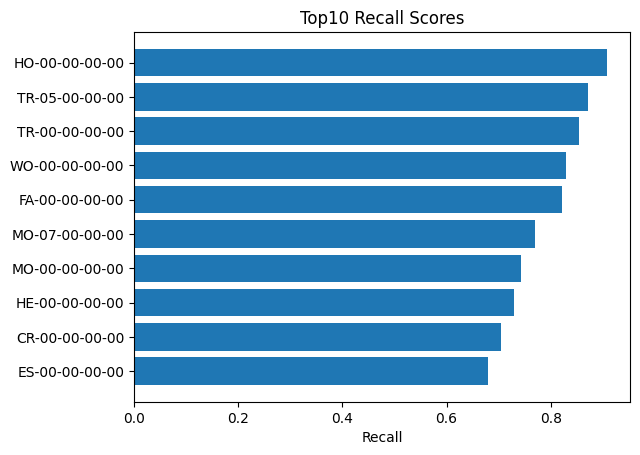

In [15]:
#for k,v in accuracy_dict.items():
#    print(k,v)
#sys.exit()


# Fixing random state for reproducibility
np.random.seed(19680801)


plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
y_pos = np.arange(10)
error = 0 

recall_dict = defaultdict()
for k,v in stat_dict.items():
    recall_dict[k] = v[2]

sorted_x = sorted(recall_dict.items(), key=lambda kv: kv[1], reverse=True)
topcat_dict = collections.OrderedDict(sorted_x)
#print(topcat_dict)

keyList = []
valList = []
for kv in topcat_dict.items():
    keyList.append(kv[0])
    valList.append(kv[1])

ax.barh(y_pos[:10], valList[:10], xerr=error, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(keyList[:10])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Recall')
ax.set_title('Top10 Recall Scores')

plt.show()

## Bottom 10

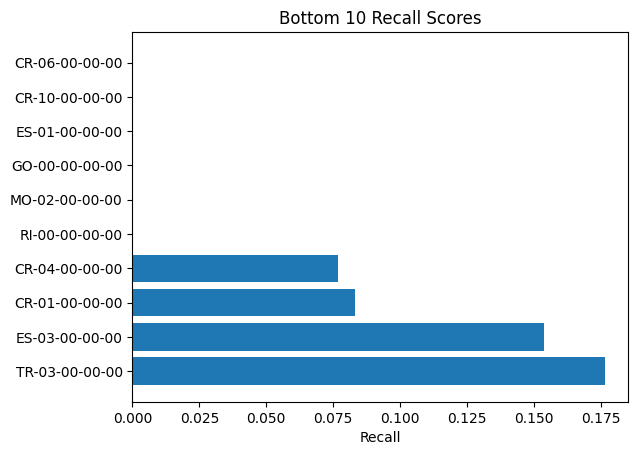

In [16]:
#for k,v in accuracy_dict.items():
#    print(k,v)
#sys.exit()

# Fixing random state for reproducibility
np.random.seed(19680801)


plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
y_pos = np.arange(10)
error = 0 

recall_dict = defaultdict()
for k,v in stat_dict.items():
    recall_dict[k] = v[2]
    
sorted_x = sorted(recall_dict.items(), key=lambda kv: kv[1])
topcat_dict = collections.OrderedDict(sorted_x)
#print(topcat_dict)

keyList = []
valList = []
for kv in topcat_dict.items():
    keyList.append(kv[0])
    valList.append(kv[1])




ax.barh(y_pos[:10], valList[:10], xerr=error, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(keyList[:10])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Recall')
ax.set_title('Bottom 10 Recall Scores')

plt.show()

## Recall Distribution

    Recall
0    40.74
1    53.76
2    66.98
3    70.53
4     8.33
5     7.69
6     0.00
7     0.00
8    41.67
9    67.95
10    0.00
11   15.38
12   82.07
13   20.00
14   40.00
15   21.95
16    0.00
17   72.95
18   90.73
19   52.94
20   40.74
21   55.56
22   74.32
23    0.00
24   76.92
25   18.18
26    0.00
27   59.57
28   85.38
29   31.82
30   37.93
31   17.65
32   40.00
33   87.10
34   82.95
35   30.00


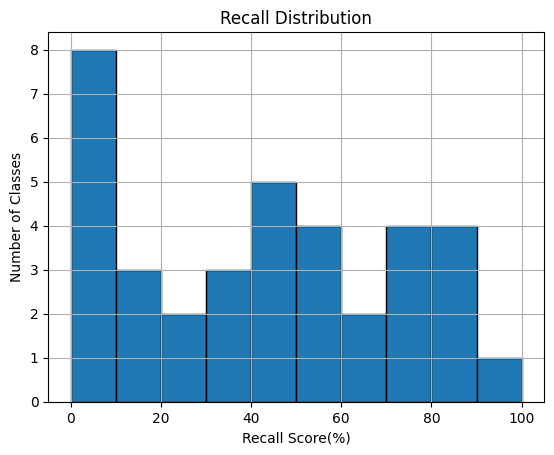

In [17]:

recall_dict = defaultdict()
for k,v in stat_dict.items():
    recall_dict[k] = v[2]

recall_list = []
for k,v in recall_dict.items():
    recall_list.append(v*100)
   
d = {'Recall': recall_list}
tinydf = pd.DataFrame(data=d)



hist = tinydf.hist(edgecolor='black', bins = [0,10,20,30,40,50,60,70,80,90,100])
pl.title("Recall Distribution")
pl.xlabel("Recall Score(%)")
pl.ylabel("Number of Classes")
print(tinydf)

## log_loss histogram

    logloss
0    0.0559
1    0.1235
2    0.1712
3    0.2196
4    0.0501
5    0.0543
6    0.0468
7    0.0428
8    0.0380
9    0.0885
10   0.0399
11   0.0427
12   0.1587
13   0.0255
14   0.0158
15   0.1043
16   0.0676
17   0.0986
18   0.1148
19   0.0594
20   0.0481
21   0.0448
22   0.2867
23   0.0549
24   0.0323
25   0.0526
26   0.0967
27   0.2799
28   0.0991
29   0.0585
30   0.0633
31   0.0462
32   0.0479
33   0.0170
34   0.1460
35   0.0397


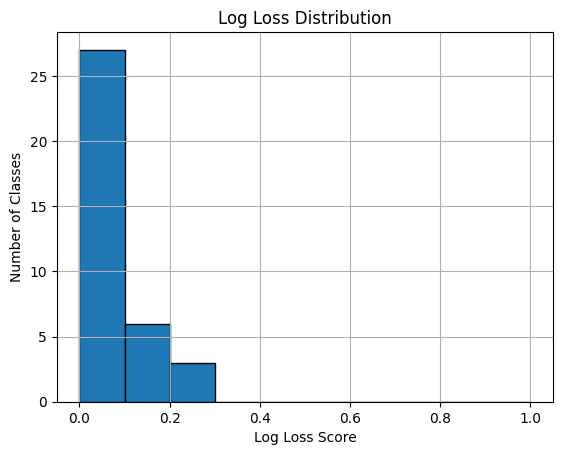

In [18]:
logloss_dict = defaultdict()
for k,v in stat_dict.items():
    logloss_dict[k] = v[5]

logloss_list = []
for k,v in logloss_dict.items():
    logloss_list.append(v)
   
d = {'logloss': logloss_list}
tinydf = pd.DataFrame(data=d)

hist = tinydf.hist(edgecolor='black', bins = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
pl.title("Log Loss Distribution")
pl.xlabel("Log Loss Score")
pl.ylabel("Number of Classes")
print(tinydf)

## Brier Score Loss

    brierloss
0      0.0115
1      0.0318
2      0.0461
3      0.0623
4      0.0092
5      0.0104
6      0.0081
7      0.0069
8      0.0089
9      0.0190
10     0.0068
11     0.0069
12     0.0428
13     0.0061
14     0.0028
15     0.0218
16     0.0121
17     0.0246
18     0.0288
19     0.0116
20     0.0111
21     0.0103
22     0.0821
23     0.0095
24     0.0078
25     0.0091
26     0.0178
27     0.0814
28     0.0247
29     0.0110
30     0.0138
31     0.0094
32     0.0096
33     0.0033
34     0.0378
35     0.0066


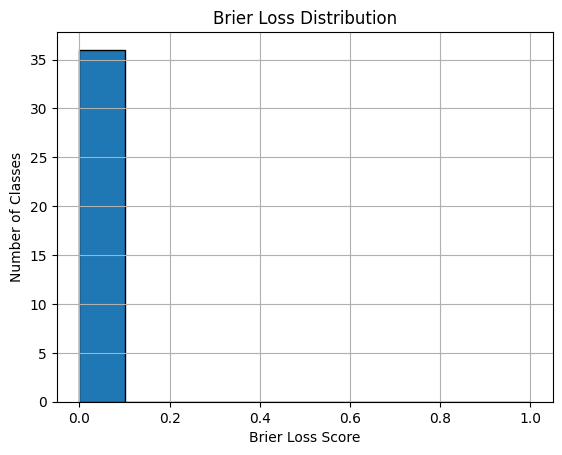

In [19]:
brierloss_dict = defaultdict()
for k,v in stat_dict.items():
    brierloss_dict[k] = v[6]

brierloss_list = []
for k,v in brierloss_dict.items():
    brierloss_list.append(v)
   
d = {'brierloss': brierloss_list}
tinydf = pd.DataFrame(data=d)

hist = tinydf.hist(edgecolor='black', bins = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
pl.title("Brier Loss Distribution")
pl.xlabel("Brier Loss Score")
pl.ylabel("Number of Classes")
print(tinydf)

# Custom Input Prediction

In [20]:
#text = "How do I get my mom's license taken away. My mom is 66, on disability for multiple sclerosis. She's been unable to work for about a decade. She has cataracts. She has neuropathy. She has 0 reaction time. She has had a fender bender on every single corner of her last car, which my brother then totaled. She also has no night vision. She also falls asleep all the time. ALMOST like like narcolepsy. It's mostly her overextending herself, but she will nod off driving or sleep in parking lots til she feels ok. She also has lymphedema in her legs which are swollen enough to impede driving. The last year she was driving she received 19 red light tickets. She agreed not to drive. And the insurance paid for her car. Now she's bought a new one, about 6 months later. Our relationship is terrible. I hate her. But I want her licence taken away before she kills or cripples someone(s). I'm no contact with her, but my brother still tries and he cares about this a lot. I've spoken with the DMV IN MY state, not very helpful. Can i contact her insurance? Do I contact the police? Has this happened to anyone"
text = "I had my car parked at work and someone stole my car. I went to report my car stolen at the police station but I got a call later saying I can’t report it stolen because a title change occurred. I never sold my car, never signed anything. I feel completely powerless and violated. I honestly don’t know what to do. If I find out who stole my car I will most likely snap because I don’t know what else to do. This has never happened to me. What legal steps can I take?"

print(text)

predictions = defaultdict() 
prob = defaultdict()


text_tfidf = tfidf_vect.transform([text])


for cls in class_list:
    predictions[cls] = classifier[cls].predict(text_tfidf)
    prob[cls] = classifier[cls].predict_proba(text_tfidf)[:,1]

for k,v in predictions.items():   
    if v > 0:
        print(k, v, end = ' ')
        print(np.round(prob[k], 4))


I had my car parked at work and someone stole my car. I went to report my car stolen at the police station but I got a call later saying I can’t report it stolen because a title change occurred. I never sold my car, never signed anything. I feel completely powerless and violated. I honestly don’t know what to do. If I find out who stole my car I will most likely snap because I don’t know what else to do. This has never happened to me. What legal steps can I take?
CR-00-00-00-00 [1.] [1.]
CR-01-00-00-00 [1.] [0.9998]
MO-00-00-00-00 [1.] [0.9604]
TO-00-00-00-00 [1.] [0.9692]
TR-00-00-00-00 [1.] [0.9999]
TR-04-00-00-00 [1.] [0.9976]
